# Conversational AI with Rasa
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)

This notebook is going to be the basis for my workshop at the PyData 2018 Amsterdam workshop. If you have any questions, please let me know!

You'll build a relatively simple bot, that just asks you about your mood and tries to cheer you up if you're feeling a bit down. 

The tutorial consists of three parts:


*   Part 0: Installation and preparations
*   Part 1: You'll start with a basic bot that can only understand natural language but no dialogues.
*   Part 2: You'll add the abilitiy to understand multiturn dialogues.
*   Part 3: I'll give you further resources so you can extend this simple demo.


## Part 0: Installation

### Let's start with jupyter configuration

In [2]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Installation of Rasa
First you'll have to install Rasa Core and NLU in this notebook if you already have them installed in your env, you can just skip this. But make sure you also have the spacy model installed!

In [2]:
import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -U rasa_core rasa_nlu[spacy];

# as well as install a language model:
!{python} -m spacy download en_core_web_md;
!{python} -m spacy link --force en_core_web_md en;

Requirement already up-to-date: rasa_core in /Users/hellohbot/.pyenv/versions/3.6.8/envs/demo/lib/python3.6/site-packages (0.12.4)
Requirement already up-to-date: rasa_nlu[spacy] in /Users/hellohbot/.pyenv/versions/3.6.8/envs/demo/lib/python3.6/site-packages (0.13.8)
  Using cached https://files.pythonhosted.org/packages/ee/3d/b25d35a9f0d381dd1c02d8e04b37c353caaaff4bc32150328eeebe4931f5/prompt_toolkit-1.0.14-py3-none-any.whl


jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.14 which is incompatible.
ipython 7.2.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.14 which is incompatible.
  Found existing installation: prompt-toolkit 2.0.7
    Uninstalling prompt-toolkit-2.0.7:
      Successfully uninstalled prompt-toolkit-2.0.7

    Linking successful
    /Users/hellohbot/.pyenv/versions/3.6.8/envs/demo/lib/python3.6/site-packages/en_core_web_md
    -->
    /Users/hellohbot/.pyenv/versions/3.6.8/envs/demo/lib/python3.6/site-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')


    Linking successful
    /Users/hellohbot/.pyenv/versions/3.6.8/envs/demo/lib/python3.6/site-packages/en_core_web_md
    -->
    /Users/hellohbot/.pyenv/versions/3.6.8/envs/demo/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



Let's check if the correct versions are installed (should be rasa_nlu: 0.12.3 rasa_core: 0.9.0) and the spacy model is available:

In [3]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

rasa_nlu: 0.13.8 rasa_core: 0.12.4
Loading spaCy language model...
Hello world!


### Some additional Tools needed
To do some of the visualizations you will also need graphviz. If you don't have graphviz installed, and this doesn't work: don't worry. I'll show you the graph and besides that visualization everything else will work.

Try installing with anyone of these (or adapt to your operating system):

In [4]:
#!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
!brew install graphviz;

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> Updated Formulae
graph-tool                 librsvg                    siril

To reinstall 2.40.1, run `brew reinstall graphviz`


and another python package and we are ready to go:

In [5]:
!{python} -m pip install pygraphviz;

## Part 1: Add natural language understanding

First thing our bot is going to learn is how to understand user messages. To do that, you're going to build a first version of your language understanding model with Rasa NLU. 

### Language Understanding


Lets create some training data here, grouping user messages by their `intent`s. The intent describes what the messages *mean*. [More information about the data format](https://nlu.rasa.com/dataformat.html#markdown-format). This is the training data for our NLU model, one example per line. Entities are labeled using the markdown link syntex: `[entity value](entity_type)`:

In [4]:
nlu_md = """
## intent:greet
- hey I am [Peter](PERSON)
- hello there I am [Hans](PERSON)
- hi I am [Tom](PERSON)
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye, from [Peter](PERSON)
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:mood_affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:mood_deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- feeling like a king
- wonderful
- I am feeling very good
- I am great
- I am amazing
- I am going to save the world
- super
- extremely good
- so so perfect
- so good
- so perfect

## intent:mood_unhappy
- my day was horrible
- I am sad
- I don't feel very well
- I am disappointed
- super sad
- I'm so sad
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not so good
- not very good
- extremly sad
- so saad
- so sad
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


To properly train your NLU model, you also need to define what is part of that model. Rasa NLU uses a similar pipeline concept as sklearn does. All the components that are listed in the pipeline will be trained one after another and everyone of them contributes its part to the structured data extraction:

In [5]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_spacy"                   # pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


You can also include your own components there - e.g. doing sentiment analysis. More information about [components and their lifecycle](https://nlu.rasa.com/pipeline.html?highlight=components#component-lifecycle).

### Train the Rasa NLU Model

You're going to train a model to recognise these intents, so that when you send a message like "hello" to your bot, it will recognise this as a `"greet"` intent.

In [9]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 68 (6 distinct intents)
	- Found intents: 'mood_unhappy', 'goodbye', 'mood_affirm', 'greet', 'mood_deny', 'mood_great'
	- entity examples: 4 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train componen

Fitting 2 folds for each of 6 candidates, totalling 12 fits


### Extending the NLU model
BUT: what about entities? Let's add some pretrained entities! https://spacy.io/api/annotation#named-entities

### Use & evaluate the NLU model
Let's play around with the model and shoot it some messages:

In [10]:
pprint(interpreter.parse("hey I am Tom"))

{
  "intent": {
    "name": "greet",
    "confidence": 0.4499532883211186
  },
  "entities": [
    {
      "entity": "PERSON",
      "value": "Tom",
      "start": 9,
      "confidence": null,
      "end": 12,
      "extractor": "ner_spacy"
    }
  ],
  "intent_ranking": [
    {
      "name": "greet",
      "confidence": 0.4499532883211186
    },
    {
      "name": "goodbye",
      "confidence": 0.17362097727480033
    },
    {
      "name": "mood_unhappy",
      "confidence": 0.15340295729136025
    },
    {
      "name": "mood_great",
      "confidence": 0.1361365648661849
    },
    {
      "name": "mood_affirm",
      "confidence": 0.04359083819571122
    },
    {
      "name": "mood_deny",
      "confidence": 0.043295374050824474
    }
  ],
  "text": "hey I am Tom"
}


Instead of evaluating it by hand, the model can also be evaluated on a test data set (though for simplicity we are going to use the same for test and train):

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 68 (6 distinct intents)
	- Found intents: 'mood_unhappy', 'goodbye', 'mood_affirm', 'greet', 'mood_deny', 'mood_great'
	- entity examples: 4 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 68 examples that have a defined intent out of 68 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.8839572192513369
INFO:rasa_nlu.evaluate:Precision: 0.9330882352941177
INFO:rasa_nlu.evaluate:Accuracy:  0.8970588235294118
INFO:rasa_nlu.evaluate:Classification report: 
              precision    recall  f1-score   support

     goodbye       1.00      0.36      0.53        11
       greet       0.65      1.00      0.79        13
 mood_affirm       1.00   

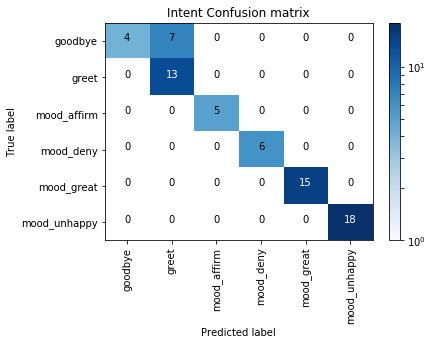

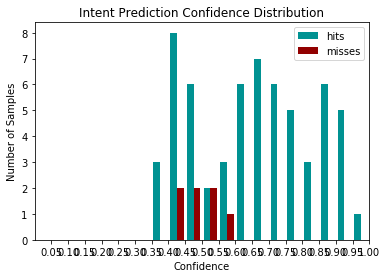

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_spacy 
INFO:rasa_nlu.evaluate:F1-Score:  0.9714078899746652
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  0.9444444444444444
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

       DATE       0.00      0.00      0.00         0
     PERSON       1.00      1.00      1.00         4
       TIME       0.00      0.00      0.00         0
  no_entity       1.00      0.94      0.97       158

avg / total       1.00      0.94      0.97       162



In [11]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

# Part 2: Adding dialogue capabilities

### Writing Stories

A good place to start is by writing a few stories. These are example conversations that Rasa Core will learn from. 

The format works like this:

A story starts with `##` and you can give it a name. 
lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. If you don't know about intents and entities, don't worry! We will talk about them more later. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

In [20]:
stories_md = """
## happy path   <!-- name of the story - just for debuggin -->
* greet
  - utter_greet
* mood_great    <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
## sad path 1   <!-- The start of the next story -->
* greet
  - utter_greet <!-- action the bot should execute -->
* mood_unhappy
  - utter_cheer_up
  - utter_did_that_help
* mood_affirm
  - utter_happy
  
## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - utter_cheer_up
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear
  
## say goodbye
* goodbye
  - utter_goodbye
  
## fallback
- utter_unclear

"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

The domain specifies the universe that your bot lives in. You should list all of the intents and actions that show up in your stories. 
This is also the place to write templates, which contain the messages your bot can send back

In [21]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_deny
- mood_great
- mood_unhappy

actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_cheer_up:
  - text: "Here is something to cheer you up: summer is around the corner!"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


In [27]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("stories.md", output_file="story_graph.html", 
                max_history=2)

Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 571.28it/s, # trackers=1]


### Training your Dialogue Model

Now comes the fun part! We're going to show Rasa Core the stories we wrote above, and train a model on these examples. 
In this case, the model is a neural network implemented in Keras which learns to predict which action to take next. 

In [15]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy()])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
)

agent.persist('models/dialogue')

Processed Story Blocks: 100%|██████████| 1/1 [00:00<00:00, 145.35it/s, # trackers=3]
Processed actions: 7it [00:00, 411.26it/s, # examples=7]
INFO:rasa_core.policies.keras_policy:Fitting model with 7 total samples and a validation split of 0.1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 16)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 10)                330       
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 6,602
Trainable params: 6,602
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 128ms/step - loss: 2.3010 - acc: 0.1429
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 2.2518 - acc: 0.1429
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 2.2796 - acc: 0

Epoch 80/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0781 - acc: 0.5714
Epoch 81/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0956 - acc: 0.4286
Epoch 82/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0202 - acc: 0.7143
Epoch 83/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0447 - acc: 0.5714
Epoch 84/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0099 - acc: 0.7143
Epoch 85/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0443 - acc: 0.7143
Epoch 86/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0398 - acc: 0.4286
Epoch 87/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0588 - acc: 0.5714
Epoch 88/100
7/7 [==============================] - 0s 1ms/step - loss: 0.9868 - acc: 0.7143
Epoch 89/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0391 - acc: 0.5714
Epoch 90/100
7/7 [==============================] - 0s 1ms/step - loss

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Persisted model to '/Users/hellohbot/study/rasa-demo-pydata18/models/dialogue'


### Starting up the bot (with NLU)

Now that we've trained the dialogue **and** language understanding models and saved them, we can start up an `Agent` which will handle conversations for us. 

In [ ]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

### Talking to the Bot (with NLU)

We can start talking to the bot in natural language.

In [ ]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


### Let's improve the bot

BUT: what if the bot doesn't get what the message means? Let's add a Fallback!

BUT: How do I execute custom code? Let's create a custom action!

### Adding Custom API methods

Sometimes, you not only want to send back messages to the user, but you also want to call an API or run some code. YOu can create custom actions that will be called once the bots ML model predicts them. You'll use that to fetch a random image from a remote server (we are not actually fetching it here, but we could ;)

In [ ]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet

import requests

class CallImageAPI(Action):
    def name(self):
        return "action_call_image_api"
    
    def run(self, dispatcher, tracker, domain):
        

### Evaluation of the dialogue model
As with the NLU model, instead of just subjectively testing the model, we can also evaluate the model on a dataset. You'll be using the training data set again, but usually you'd use a test data set separate from the training data.

In [ ]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")

### Interactive learning
Unfortunately, this doesn't work in jupyter yet. Hence, we going to do this on the command line. [The repository](https://github.com/tmbo/rasa-demo-pydata18)  contains a makefile with the instructions to run the interactive learning. So go ahead and run `make interactive` on the commandline (make sure your shell is in the righht virtual env).

# Part 3: Next steps

Great job! You've built your first bot that uses Machine Learning to manage dialogues. As a next step, we'd suggest you start building your own bot. Here are a few useful links:



*   Install the Rasa Stack on your machine [here](https://core.rasa.ai/installation.html)
*   Checkout more of the Docs: [NLU](https://nlu.rasa.com) and [Core](https://core.rasa.com)
*   Connect to the community in our [Gitter Chat](https://gitter.im/RasaHQ/rasa_core)



---




*Any feedback for this tutorial?* Please shoot me a mail at tom@rasa.com

# Scratch

In [18]:
import spacy

In [21]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')


In [22]:
# Process whole documents
text = (u"When Sebastian Thrun started working on self-driving cars at "
        u"Google in 2007, few people outside of the company took him "
        u"seriously. “I can tell you very senior CEOs of major American "
        u"car companies would shake my hand and turn away because I wasn’t "
        u"worth talking to,” said Thrun, now the co-founder and CEO of "
        u"online higher education startup Udacity, in an interview with "
        u"Recode earlier this week.")
doc = nlp(text)

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)



Sebastian Thrun PERSON
Google ORG
2007 DATE
American NORP
Thrun PERSON
Recode ORG
earlier this week DATE


In [23]:
# Determine semantic similarities
doc1 = nlp(u"my fries were super gross")
doc2 = nlp(u"such disgusting fries")
similarity = doc1.similarity(doc2)
print(doc1.text, doc2.text, similarity)

my fries were super gross such disgusting fries 0.7139701576579747


In [20]:
!python -m spacy download en_core_web_sm

    100% |████████████████████████████████| 37.4MB 54.6MB/s ta 0:00:01    82% |██████████████████████████▎     | 30.7MB 13.7MB/s eta 0:00:01
  Running setup.py install for en-core-web-sm ... done

    Linking successful
    /Users/hellohbot/.pyenv/versions/demo/lib/python3.6/site-packages/en_core_web_sm
    -->
    /Users/hellohbot/.pyenv/versions/demo/lib/python3.6/site-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



In [24]:
!python -V

Python 3.6.8
